In [1]:
%matplotlib inline
import argparse
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn.functional as F

from discrete_flows import *

In [2]:
## 参数设置
# pytorch discretized mixture of Gaussians
disc_layer_type = 'autoreg' # 'autoreg' | 'bipartite'
cuda_device = 'cuda:0'
no_cuda = False
seed = 1
batch_size = 1024
sequence_length = 2
vocab_size = 91
num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
nh = 8 # number of hidden units per layer
n_hid = 2 # number of hidden layers
vector_length = sequence_length*vocab_size
lr = 0.01
epochs = 1500
print_loss_every = epochs//10

cuda = not no_cuda and torch.cuda.is_available()
device = torch.device(cuda_device if cuda else "cpu")

np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [3]:
## 数据下载
def sample_quantized_gaussian_mixture(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                                             [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                                             [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                                             [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

data = sample_quantized_gaussian_mixture(batch_size)

Text(0.5, 1.0, 'Data Distribution')

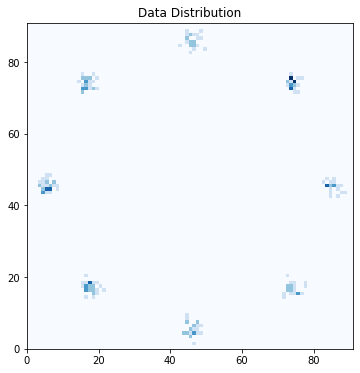

In [4]:
figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
ax.set_title("Data Distribution")

In [5]:
## 模型及优化器
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        layer = MADE(sequence_length, nh, n_hid, vocab_size)
        
        disc_layer = DiscreteAutoregressiveFlow(layer, temperature, vocab_size)
    
    elif disc_layer_type == 'bipartite':
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, vocab_size, vector_length, embedding=True)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)

In [6]:
base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':lr},
            {'params': base_log_probs, 'lr': lr}
        ])

epoch: 0 loss: 10.104317665100098
epoch: 150 loss: -0.0
epoch: 300 loss: -0.0
epoch: 450 loss: -0.0
epoch: 600 loss: -0.0
epoch: 750 loss: -0.0
epoch: 900 loss: -0.0
epoch: 1050 loss: -0.0
epoch: 1200 loss: -0.0
epoch: 1350 loss: -0.0


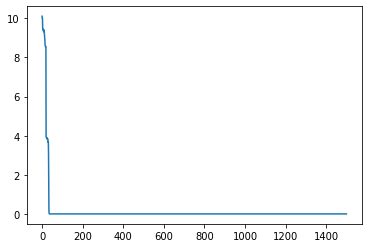

In [7]:
## 训练和测试
losses = []
model.train()
for e in range(epochs):
    x = sample_quantized_gaussian_mixture(batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()
    
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())
plt.plot(losses)

In [8]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()
figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()

ValueError: Inverse for 0 modulo 91 does not exist.